In [1]:
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from pyvis.network import Network
import community.community_louvain as community_louvain
from tqdm import tqdm

In [2]:
%matplotlib notebook

Importation des données : 

In [3]:
project = pd.read_csv("../Data/CSV/Projects/project.csv", sep=";")

In [4]:
organization = pd.read_csv("../Data/CSV/Projects/organization.csv", sep=";")

Point positif des CSV c'est qu'ils semblent plus propre que les JSON (voir Publications) et les columnes sont dans le bon ordre.

In [5]:
print(project.shape)
print(organization.shape)

(35381, 20)
(177190, 25)


In [6]:
project.columns

Index(['id', 'acronym', 'status', 'title', 'startDate', 'endDate', 'totalCost',
       'ecMaxContribution', 'legalBasis', 'topics', 'ecSignatureDate',
       'frameworkProgramme', 'masterCall', 'subCall', 'fundingScheme',
       'nature', 'objective', 'contentUpdateDate', 'rcn', 'grantDoi'],
      dtype='object')

In [7]:
organization.columns

Index(['projectID', 'projectAcronym', 'organisationID', 'vatNumber', 'name',
       'shortName', 'SME', 'activityType', 'street', 'postCode', 'city',
       'country', 'nutsCode', 'geolocation', 'organizationURL', 'contactForm',
       'contentUpdateDate', 'rcn', 'order', 'role', 'ecContribution',
       'netEcContribution', 'totalCost', 'endOfParticipation', 'active'],
      dtype='object')

On vérifie si on a autant de projectID unique que de ligne dans notre table *project*. Et c'est le cas ! 

In [8]:
len(organization["projectID"].unique())

35381

In [9]:
project.head(1)

,id,acronym,status,title,startDate,endDate,totalCost,ecMaxContribution,legalBasis,topics,ecSignatureDate,frameworkProgramme,masterCall,subCall,fundingScheme,nature,objective,contentUpdateDate,rcn,grantDoi
0,817296,eDCaseMAN,CLOSED,"Defendable legal cases through an affordable, ...",2018-05-01,2018-09-30,71429,50000,H2020-EU.2.3.,EIC-SMEInst-2018-2020,2018-05-02,H2020,H2020-EIC-SMEInst-2018-2020,H2020-SMEInst-2018-2020-1,SME-1,NaN,"""Electronic discovery (known as e-discovery) i...",2022-08-10 13:07:21,217713,10.3030/817296


In [10]:
organization.head(1)

,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,...,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active
0,817296,eDCaseMAN,907916509,CHE385284385MWST,BRITE GMBH,Brite GmbH,True,PRC,AUF DER SCHANZ 9,4132,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-10 13:07:21,1952575,1,coordinator,50000.0,50000.0,71429,False,NaN


In [11]:
project_id = list(project["id"].unique())
print(len(project_id))

35381


On a autant de projectID unique que de lignes dans project ! 

---

Affichons de manière aléatoire toutes les organisation appartenant à un projet (tiré aléatoirement).

In [16]:
organization[organization["projectID"] == random.choice(project_id)]

,projectID,projectAcronym,organisationID,vatNumber,name,shortName,SME,activityType,street,postCode,...,contactForm,contentUpdateDate,rcn,order,role,ecContribution,netEcContribution,totalCost,endOfParticipation,active
116719,688612,CONNECT,999984059,DE129515865,FRAUNHOFER GESELLSCHAFT ZUR FORDERUNG DER ANGE...,FHG,False,REC,HANSASTRASSE 27C,80686,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,1905912,1,coordinator,1187378.80,1187378.80,"1187378,8",False,NaN
116720,688612,CONNECT,999992401,FR43775685019,COMMISSARIAT A L ENERGIE ATOMIQUE ET AUX ENERG...,CEA,False,REC,RUE LEBLANC 25,75015,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,1905694,2,participant,1044500.00,1044500.00,1044500,False,NaN
116721,688612,CONNECT,999909854,CHE110354546MWST,IBM RESEARCH GMBH,IBM,False,PRC,SAEUMERSTRASSE 4,8803,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,1914585,5,participant,0.00,0.00,561395,False,NaN
116722,688612,CONNECT,984534481,GB988376152,Gold Standard Simulations ltd,GSS,True,PRC,Mitchell Street 90 Gordon Chambers,G1 3NQ,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,2072089,6,participant,134223.90,134223.90,"134223,9",True,NaN
116723,688612,CONNECT,968598157,GB537505345,SYNOPSYS (NORTHERN EUROPE) LIMITED,SYNOPSYS (NORTHERN EUROPE) LIMITED,False,PRC,BROOK DRIVE 100 GREEN PARK,RG2 6UJ,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,3099822,8,participant,166276.10,166276.10,"166276,1",False,NaN
116724,688612,CONNECT,999974165,GB671798093,UNIVERSITY OF GLASGOW,UGLA,False,HES,UNIVERSITY AVENUE,G12 8QQ,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,1906499,7,participant,200450.00,200450.00,200450,False,NaN
116725,688612,CONNECT,999997930,FR40180089013,CENTRE NATIONAL DE LA RECHERCHE SCIENTIFIQUE CNRS,CNRS,False,REC,RUE MICHEL ANGE 3,75794,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,1905572,3,participant,380043.75,380043.75,"380043,75",False,NaN
116726,688612,CONNECT,953168173,GB740670640,AIXTRON LIMITED,AIX.L,False,PRC,ANDERSON ROAD BUCKINGWAY BUSINESS PARK SWAVESEY,CB24 5FQ,...,https://ec.europa.eu/info/funding-tenders/oppo...,2022-08-11 18:37:59,1913417,4,participant,325000.00,325000.00,325000,False,NaN


Comptons le nombre d'organisations différentes.

In [17]:
len(organization["organisationID"].unique())

41338

Pour chaque projet je récupère les id des organisations qui y participent. Tout ça dans un dictionnaire.

In [12]:
projet_orga = {}
for projet in project_id:
    projet_orga[projet] = list(organization[organization["projectID"] == projet]["organisationID"])

In [19]:
G = nx.Graph()

In [209]:
yes_counter = 0
for i in range(1, len(projet_orga.keys())):
#     print(projet_orga[project_id[i]])
    G.add_node(project_id[i - 1])
    for y in projet_orga[project_id[i - 1]]:
#         print(f"i: {i} | i+1: {projet_orga[project_id[i+1]]} | y: {y}")
        if G.has_edge(project_id[i - 1], project_id[i]) is False:
            for x in projet_orga[project_id[i]]:
            
                if y == x:
                    yes_counter += 1
                    G.add_edge(project_id[i-1], project_id[i])

100%|███████████████████████████████████████████████████████████████████████▉| 35379/35381 [00:00<00:00, 300709.03it/s]


In [213]:
########### /!\ TOURNE INDEFINIEMENT /!\ ##############

yes_counter = 0
for i, tq in zip(range(1, len(projet_orga.keys())), tqdm(range(len(projet_orga.keys())))):
#     print(projet_orga[project_id[i]])
    for t in range(len(projet_orga.keys())):
        G.add_node(project_id[i - 1])
        for y in projet_orga[project_id[i - 1]]:
#         print(f"i: {i} | i+1: {projet_orga[project_id[i+1]]} | y: {y}")
            if G.has_edge(project_id[i - 1], project_id[t]) is False:
                for x in projet_orga[project_id[t]]:
            
                    if y == x:
                        yes_counter += 1
                        G.add_edge(project_id[i-1], project_id[t])

 14%|██████████▍                                                                  | 4790/35381 [06:38<42:24, 12.02it/s]


KeyboardInterrupt: 

Trouver un moyen d'enlever les doublons. Par doublons j'entend les combinaisons déjà essayé. Par exemple une fois avoir tester le projet 1 sur tous les autres, ceux où une arrête a été ajouté ne repasse pas. Si y'a une arrête entre 1 et 2 quand on fera tourner 2 on ne regarde pas s'il existe une arrête entre les 2. <br>
<br>
Test un truc style : <br>
`
if G.has_edge(project_id[i], project_id[t]) is False: 
    suite du code...
else: 
    pass
`

On enregristre le graphe :

In [66]:
pickle.dump(G, open('graphe_2.pickle', 'wb'))

In [14]:
 G = pickle.load(open("./graphs_save/graph.pickle", "rb"))

Pour l'ouvrir il suffira d'utiliser cette line de code : 
G = pickle.load(open("filename.pickle", "rb"))

_Je crois que cela n'est pas bon ! Je crois qu'on ne prend les projets que 2 par 2 et pas 1 projet qui regarde les correspondace avec tous les autres etc..._

In [82]:
yes_counter

12516

In [15]:
G.number_of_nodes()

35381

In [16]:
G.number_of_edges()

10022032

Notre graphe ne contient donc que les projets où une des organisation à travailler pour un autre projet ! Donc on n'a pas les organisations qui n'ont pas fait 2 projets. 
Pour régler cela nous avons ajouté *G.add_node()* dans la cellule avec les boucle, en y mettant TOUS les id des projets !

Affichons maintenant les graphes

In [34]:
nx.draw_networkx(G)

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


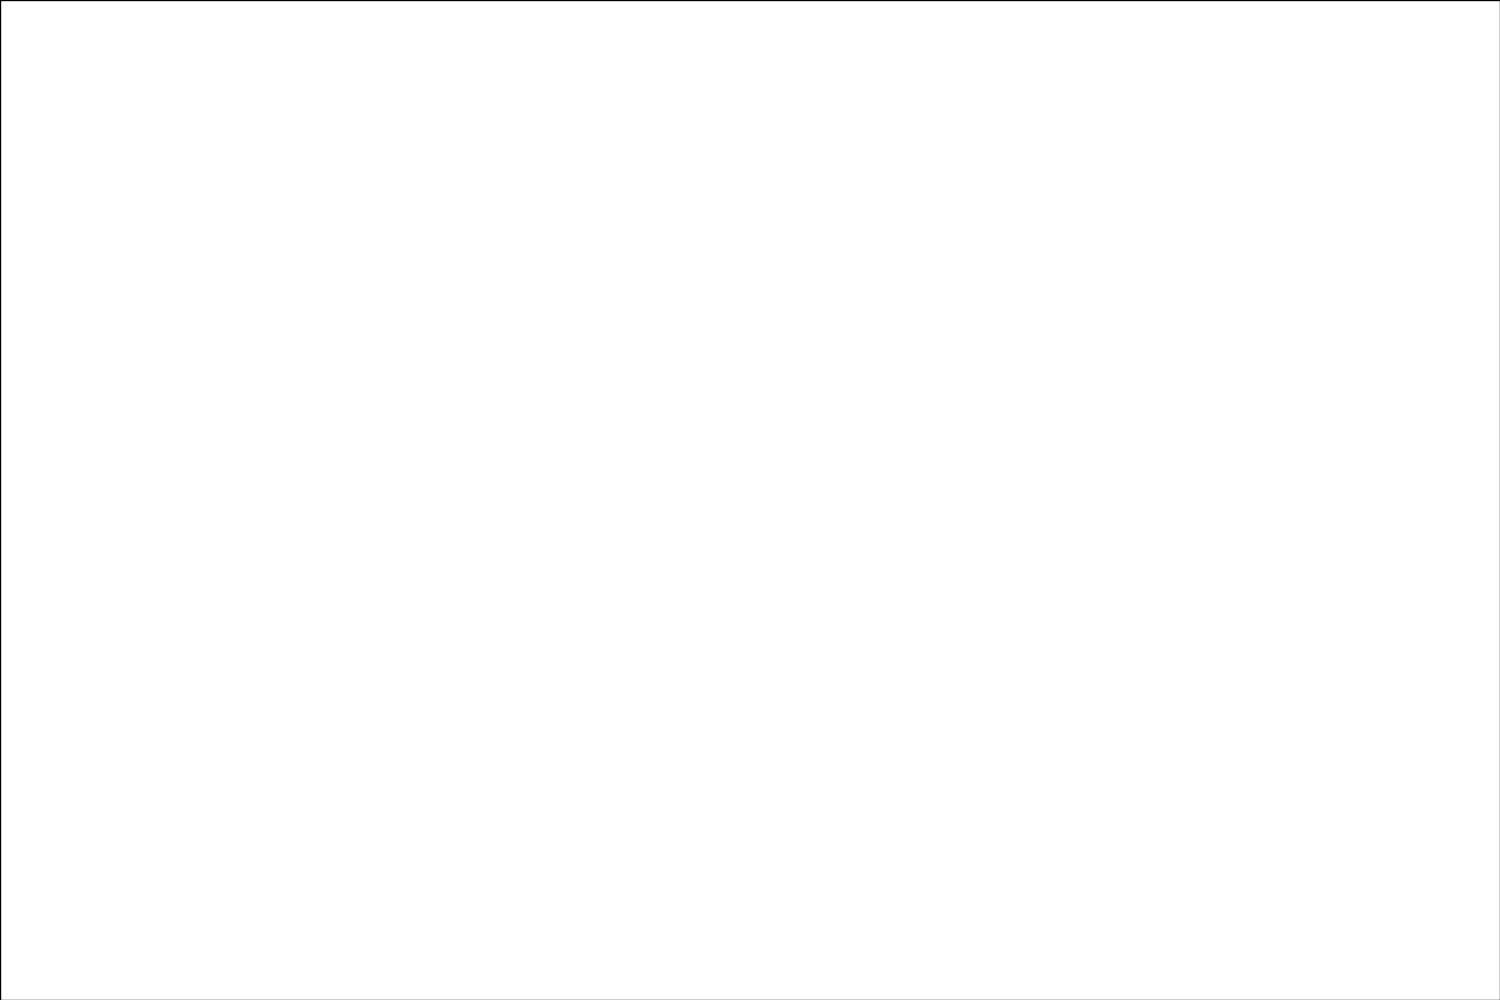

KeyboardInterrupt: 

In [107]:
plt.figure(figsize=(12, 8))

graph_options = {
    'node_color': 'lightblue',
    'node_size' : 10,
    "edge_color": 'black'
}

nx.draw(G, **graph_options)
plt.show()

On va tester une solution venu de stackoverflow:

In [110]:
from matplotlib import pylab
import networkx as nx

def save_graph(graph, file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

<IPython.core.display.Javascript object>


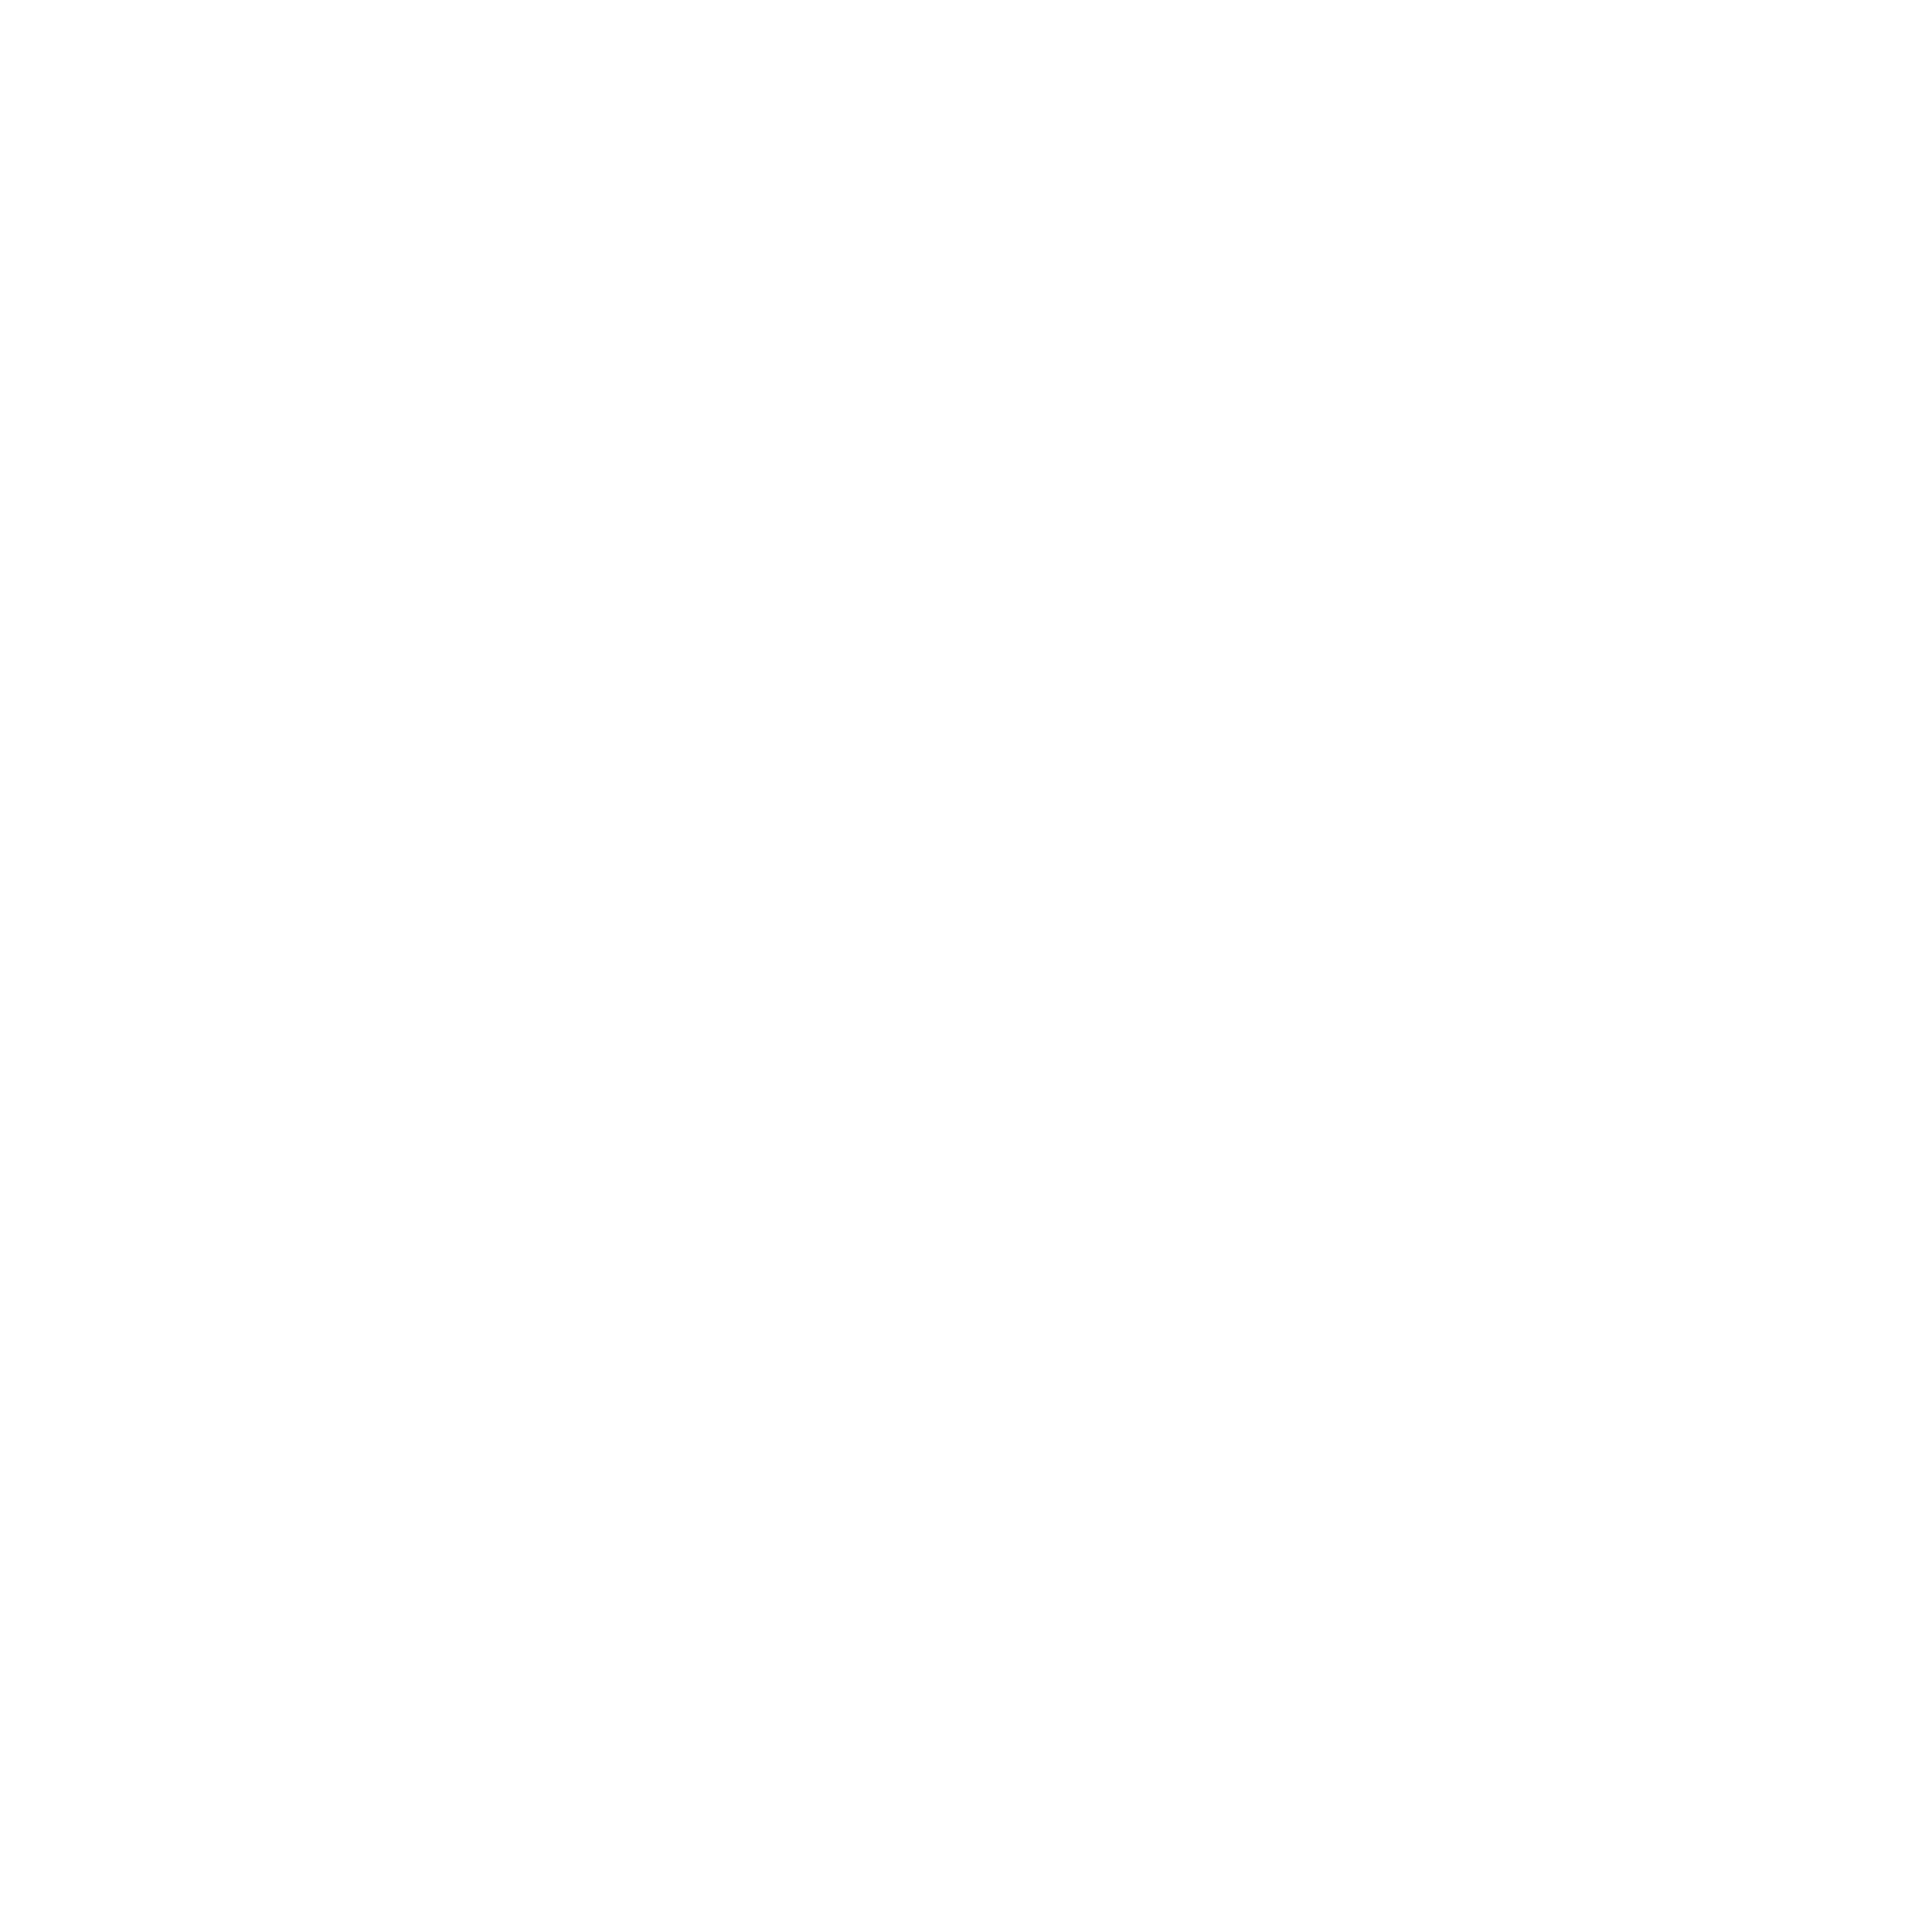

KeyboardInterrupt: 

In [111]:
#Assuming that the graph g has nodes and edges entered
save_graph(G,"my_graph_test.pdf")

On va essayer d'utiliser la librairie PyVis :
NON FONCTIONNEL

In [86]:
net = Network(notebook=True, cdn_resources="remote")

In [103]:
net.from_nx(G)

AssertionError: 

In [71]:
net.show("graph_2.html")

---

On va tester de faire une détection de communauté avec l'algo de Louvain

In [ ]:
partition = community_louvain.best_partition(G)

In [ ]:
len(partition)

In [ ]:
partition_sorted = dict(sorted(partition.items()))

In [ ]:
partition_sorted = pd.DataFrame.from_dict(partition_sorted, orient="index")

In [ ]:
project = project.join(partition_sorted, on="id")

In [ ]:
project.rename({0:"Community"}, axis=1, inplace=True)

In [ ]:
project

Il manque la dernière valeur ! Il faut aussi modifier dtype de *Community* passer de float à int.